# Custom Gates and Gate Implementations

This notebook demonstrates how to work with user-defined quantum operations and gate implementations that go beyond the standard gate set.

Each quantum operation is associated with one or more `GateImplementation`s which translate the high-level concepts to lower-level instructions accepted by the IQM server. This example shows how the user can

- Selecting a non-default implementation for a gate
- Add a custom implementation for an existing gate
- Add a custom gate and a custom implementation for it
  - by using existing gates as building blocks (composite gates)
- Defining new pulse waveforms for implementations


## Environment setup

Please refer to the `User Guide.ipynb` for basic usage, termninology, and environment setup.

In [15]:
import os
from pprint import pprint
from iqm.qiskit_iqm import IQMProvider
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from iqm.pulla.pulla import Pulla
from iqm.pulla.utils_qiskit import qiskit_to_pulla
from iqm.pulse.playlist.visualisation.base import inspect_playlist
from IPython.core.display import HTML
import logging

In [ ]:
cocos_url = os.environ['PULLA_COCOS_URL']  # or set the URL directly here
station_control_url = os.environ['PULLA_STATION_CONTROL_URL']  # or set the URL directly here

p = Pulla(station_control_url)

provider = IQMProvider(cocos_url)
backend = provider.get_backend()

[10-31 21:33:24;W] station-control-client version '1.18' is newer minor version than '1.13' used by the station control server, some new client features might not be supported.


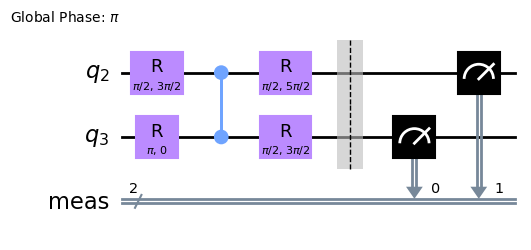

In [17]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile


def example_qiskit_circuit():
    qc = QuantumCircuit(2, 2)
    qc.x(0)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure_all()

    transpiled_qc = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
    transpiled_qc = optimize_single_qubit_gates(transpiled_qc)
    return transpiled_qc


example_qiskit_circuit().draw(output='mpl', style='clifford', idle_wires=False)

## Changing implementations at the circuit level

Circuits are usually defined without specifying implementations for any of the gates.
The implementations available in a given calibration set are listed in the corresponding dynamic quantum architecture, through Cocos.

Let's see a list of available implementations, with their parameters:

In [18]:
circuits, compiler = qiskit_to_pulla(p, backend, example_qiskit_circuit())

compiler.print_all_implementations_trees()

Operation: barrier

 "Operation: barrier, implementation: "
-----------------------------------

Operation: measure

 "Operation: measure, implementation: constant"
 ╠─ duration: Readout pulse duration = None (automatic/unspecified)
 ╠─ frequency: Readout pulse frequency = None (automatic/unspecified)
 ╠─ phase: Readout pulse phase = None (automatic/unspecified)
 ╠─ amplitude_i: Readout channel I amplitude = None (automatic/unspecified)
 ╠─ amplitude_q: Readout channel Q amplitude = 0.0 
 ╠─ integration_length: Integration length = None (automatic/unspecified)
 ╠─ integration_weights_I: Integration weights for channel I = [] 
 ╠─ integration_weights_Q: Integration weights for channel Q = [] 
 ╠─ integration_threshold: Integration threshold = None (automatic/unspecified)
 ╠─ acquisition_type: Acquisition type = threshold 
 ╚─ acquisition_delay: Acquisition delay = None (automatic/unspecified)

 "Operation: measure, implementation: constant_qnd"
 ╠─ duration: Readout pulse duration = Non

You can specify a default implementation for each native operation type in the circuit, and then override it for specific loci.
Let's change all `cz` gates to use the `slepian` implementation, and make an execption for the qubit pair `(QB1, QB2)`.

In [19]:
compiler.set_default_implementation('cz', 'slepian')
compiler.set_default_implementation_for_loci('cz', 'tgss', [('QB1', 'QB2')])

Note that the default implementations are merely suggestions to the compiler. If the compiler does not have calibration data for a default implementation, it will ignore it and use what it can.

If you executed the cell below, you would get an error 
```
Error in stage "circuit" pass "map_implementations_for_loci": Circuit 0: No calibration data for 'prx.drag_gaussian' at ('QB1',).
```
if the requested implementation `'drag_gaussian'` does not have calibration data.

In [ ]:
circuits[0].instructions[0].implementation = 'drag_gaussian'
# _, context = compiler.compile(circuits) # Fails

You can also force the compiler to use a specific implementation for each circuit instruction separately in the IQM Pulse native format, which describes a circuit as a list of `CircuitOperation` instances.

## Custom gates: Composite gates

IQM Pulse allows the user to define composite gates: gates consisting of other registered gates.
Composite gates are particularly useful because they allow reusing the calibrated of data of the other gates.
Furthermore, it is possible to use different calibration data for the registered gates inside a composite gate than outside it.

Let's define a `prx` implementation that acts like a normal `prx`, except it implements `x` with 2 pulses with a 100 ns wait between them.
The `__call__` method produces a TimeBox using IQM Pulse's ScheduleBuilder.
It's worth mentioning that the composite gate is not restricted to using only registered gates; it could equally well return a TimeBox with lower level instructions.

In [20]:
from iqm.pulse.gate_implementation import CompositeGate
import numpy as np


class StretchedX(CompositeGate):
    registered_gates = ['prx']  # use the standard prx as a building block

    def __call__(self, angle_t: float, phase_t: float):
        normal_prx = self.build("prx", self.locus)
        # convert args to radians, which is what prx uses on the schedule level
        phase = phase_t * 2 * np.pi
        angle = angle_t * 2 * np.pi
        if angle_t != 0.5:
            return normal_prx(angle, phase)

        half = normal_prx(np.pi / 2, phase)
        return half + self.builder.wait(self.locus, 100e-9, rounding=True) + half

Now we register a new gate `custom_x`, which `StretchedX` implements. We want to make it compatible with the circuit-level `prx`, so we declare that it has the same parameters.
Then we change the fist `prx` in the IQM Pulse circuit to use our new implementation.

In [21]:
circuits, compiler = qiskit_to_pulla(p, backend, example_qiskit_circuit())
compiler.add_implementation('custom_x', 'StretchedX', StretchedX, quantum_op_specs={'params': ('angle_t', 'phase_t')})

c = circuits[0]
for inst in c.instructions:
    if inst.name == 'prx':
        inst.name = 'custom_x'

playlist, _ = compiler.compile(circuits)

Inspecting the schedule, we can see that the `X` gate in the circuit is indeed split into two pulses with a wait in between:

In [ ]:
HTML(inspect_playlist(playlist, [0]))

## Custom gates: Custom waveforms

Finally, let's change the pulse waveforms of an existing gate. The tricky part of this is that we need to provide the calibration data by hand.
IQM Pulse provides several "gate with custom waveforms" base classes so that users need only write the waveforms. 

Let's define a new implementation of PRX using a raised cosine pulse:

In [23]:
from iqm.pulse.gates.prx import PRX_CustomWaveforms
from dataclasses import dataclass
from iqm.pulse.playlist.waveforms import Gaussian, GaussianDerivative, Waveform
import numpy as np


@dataclass(frozen=True)
class RaisedCosine(Waveform):
    r"""Raised cosine pulse.

    .. math::
        f(t) = \frac{1}{2} (1 + \cos((t - c) \pi / w)) \quad \text{when} \: |t - c| \le w, 0 \: \text{otherwise}

    where :math:`c` is :attr:`center_offset`, and :math:`w` is :attr:`width`.
    The raised cosine has a finite support.

    Args:
        width: half-width of the support
        center_offset: center offset
    """

    width: float
    center_offset: float = 0.0

    def _sample(self, sample_coords: np.ndarray) -> np.ndarray:
        offset_coords = sample_coords - self.center_offset
        return np.where(
            np.abs(offset_coords) <= self.width,
            0.5 * (1 + np.cos(offset_coords * np.pi / self.width)),
            0.0,
        )


@dataclass(frozen=True)
class RaisedCosineDerivative(Waveform):
    r"""Scaled derivative of the RaisedCosine pulse.

    .. math::
        f(t) = -\sin((t - c) \pi / w) \quad \text{when} \: |t - c| \le w, 0 \: \text{otherwise}

    where :math:`c` is :attr:`center_offset`, and :math:`w` is :attr:`width`.

    Args:
        width: half-width of the support
        center_offset: center offset
    """

    width: float
    center_offset: float = 0.0

    def _sample(self, sample_coords: np.ndarray) -> np.ndarray:
        offset_coords = sample_coords - self.center_offset
        return np.where(
            np.abs(offset_coords) <= self.width,
            -0.5 * np.sin(offset_coords * np.pi / self.width),
            0.0,
        )


class PRX_RaisedCosine(PRX_CustomWaveforms, wave_i=RaisedCosine, wave_q=RaisedCosineDerivative):
    """Implementation of PRX using a raised cosine pulse."""

    center_offset: float = 0.0

The class attributes of the waveforms define the calibration data they require. The `PRX_CustomWaveforms` class adds some more. We can add the new `prx` implementation to the compiler, and check what calibration data it needs:

In [24]:
circuits, compiler = qiskit_to_pulla(p, backend, example_qiskit_circuit())

compiler.add_implementation('prx', 'raised_cosine', PRX_RaisedCosine)
compiler.print_implementations_trees(compiler.builder.op_table['prx'])


 "Operation: prx, implementation: drag_gaussian"
 ╠─ duration: pi pulse duration = None (automatic/unspecified)
 ╠─ amplitude_i: pi pulse I channel amplitude = None (automatic/unspecified)
 ╠─ amplitude_q: pi pulse Q channel amplitude = None (automatic/unspecified)
 ╠─ full_width: full_width of tg = None (automatic/unspecified)
 ╚─ center_offset: center_offset of tg = 0.0 s

 "Operation: prx, implementation: drag_crf"
 ╠─ duration: pi pulse duration = None (automatic/unspecified)
 ╠─ amplitude_i: pi pulse I channel amplitude = None (automatic/unspecified)
 ╠─ amplitude_q: pi pulse Q channel amplitude = None (automatic/unspecified)
 ╠─ full_width: full_width of crf = None (automatic/unspecified)
 ╚─ center_offset: center_offset of crf = 0.0 s

 "Operation: prx, implementation: drag_crf_sx"
 ╠─ duration: pi pulse duration = None (automatic/unspecified)
 ╠─ amplitude_i: pi pulse I channel amplitude = None (automatic/unspecified)
 ╠─ amplitude_q: pi pulse Q channel amplitude = None (autom

Let us then make one of the `prx` gates in the circuit use our new implementation:

In [25]:
circuits[0].instructions[0].implementation = "raised_cosine"

Compiling this circuit right now would fail with an error:

```
Error in stage "circuit" pass "map_implementations_for_loci": Circuit 0: No calibration data for 'prx.raised_cosine' at ('QB1',).
```

(The locus ('QB1',) may differ in your output due to the stochastic nature of routing.)

The point is that the compiler does not have necessary calibration data for this new implementation. One way to fix this is to amend the current calibration. The numbers here are arbitrary, in reality you would need to calibrate the gate parameters somehow.

In [26]:
custom_cal_data = {
    "duration": 40e-09,
    "amplitude_i": 0.1662,
    "amplitude_q": -0.00802,
    "width": 20e-9,
    "center_offset": 3e-9,
}

for qubit in compiler.builder.chip_topology.qubits:
    compiler.amend_calibration_for_gate_implementation('prx', 'raised_cosine', (qubit,), custom_cal_data)

Data with `gates.prx.raised_cosine.*` is now visible in `compiler.get_calibration()`. Note that we added the same calibration data to all qubits. In practice, this rarely makes sense, because each qubit
is usually calibrated differently.

Now the compilation succeeds and we see that `raised_cosine` was used once. Using the schedule visualization you could also verify that the pulse shape is indeed different on the first `prx` instance.

In [27]:
playlist, context = compiler.compile(circuits)
pprint(context['circuit_metrics'][0].gate_loci["prx"])

{'drag_crf': Counter({('QB3',): 2, ('QB1',): 1}),
 'raised_cosine': Counter({('QB1',): 1})}
